In [4]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: Jan 24, 2018

import sys
sys.path.append("./utils/") # Adds higher directory to python modules path.
import random
import numpy as np
import cv2
import loadcoraldata_utils as coralutils
import glob, os

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
import pandas as pd
import logging
import yaml
from PIL import Image as pil_image

import keras
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, Convolution2D, MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import img_to_array
from keras.callbacks import Callback
from NeMO_models import FCN
import NeMO_layers
from NeMO_generator import NeMOImageGenerator, ImageSetLoader

from collections import Counter

%matplotlib notebook

model = load_model('./output/weights_NeMO_AlexNet_hyperas1.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D})

In [5]:
# Test export of patches from gdal
imgpath = '../Images/BTPB-WV2-2012-15-8Band-mosaic-GeoTiff-Sample-AOI/BTPB-WV2-2012-15-8Band-mosaic-GeoTiff-Sample-AOI.tif'
tfwpath = '../Images/BTPB-WV2-2012-15-8Band-mosaic-GeoTiff-Sample-AOI/BTPB-WV2-2012-15-8Band-mosaic-GeoTiff-Sample-AOI.tfw'
truthpath = '../Images/BIOT-PerosBanhos-sample-habitat-map/BIOT-PerosBanhos-sample-habitat-map.shp'
output_trainpath = '../Images/LO_Training_Patches/'
output_trainrefpath = '../Images/LO_TrainingRef_Patches/'
output_trainfilename = 'rastertrain.txt'
output_validpath = '../Images/LO_Valid_Patches/'
output_validrefpath = '../Images/LO_ValidRef_Patches/'
output_validfilename = 'rastervalid.txt'

PerosBanhos = coralutils.CoralData(imgpath, Truthpath=truthpath, load_type="raster", tfwpath=tfwpath)

pixel_mean =1023.5*np.ones(8)
pixel_std = 1023.5*np.ones(8)
datagen = NeMOImageGenerator(image_shape = (25,25,8),
    image_resample=True, pixelwise_center=True,
    pixel_mean=pixel_mean, pixelwise_std_normalization=True,
    pixel_std=pixel_std)

train_generator = datagen.flow_from_NeMOdirectory(output_trainpath,
    target_size=(25,25),
    color_mode='8channel',
    classes = PerosBanhos.class_labels,
    class_mode = 'categorical',
    batch_size = 120,
    shuffle=True)

Found 48000 images belonging to 24 classes.


(3272, 4330, 8)
(300, 500, 8)
{'NoData': 0, 'back reef - pavement': 1, 'back reef - rubble dominated': 2, 'back reef - sediment dominated': 3, 'back reef coral framework': 4, 'Beach': 5, 'Clouds': 6, 'coralline algal ridge (reef crest)': 7, 'deep fore reef slope': 8, 'deep lagoonal water': 9, 'deep ocean water': 10, 'dense seagrass meadows': 11, 'fore reef sand flats': 12, 'Inland waters': 13, 'lagoonal floor - barren': 14, 'lagoonal fringing reefs': 15, 'lagoonal patch reefs': 16, 'lagoonal sediment apron - sediment dominated': 17, 'mangroves': 18, 'Rocky beach': 19, 'shallow fore reef slope': 20, 'shallow fore reef terrace': 21, 'terrestrial vegetation': 22, 'Wetlands': 23}
[12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 2

<IPython.core.display.Javascript object>


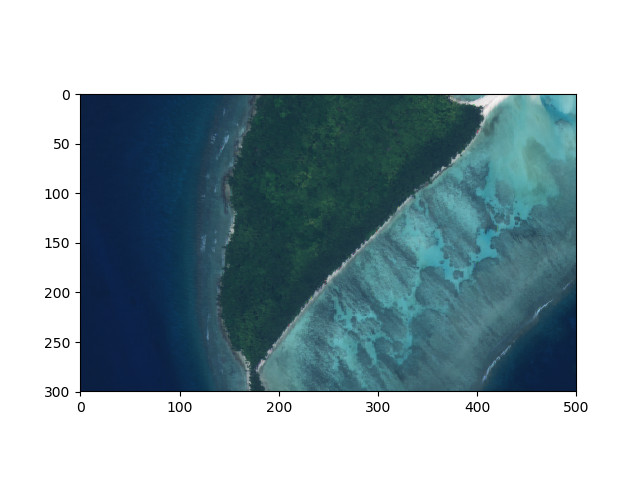

In [6]:
xstart = 700
xlen = 300
ystart = 500
ylen = 500

PerosBanhos.testimage = PerosBanhos.image[xstart:xstart+xlen, ystart:ystart+ylen,:]
crop_len = 12
Testtruth = PerosBanhos.truthimage[xstart+crop_len:xstart+xlen-crop_len, ystart+crop_len:ystart+ylen-crop_len]
print(PerosBanhos.image.shape)
print(PerosBanhos.testimage.shape)
#print(PerosBanhos.class_labels)
print(train_generator.class_indices)
Perostest_RGB = np.rollaxis(np.asarray([1/1016*PerosBanhos.testimage[:,:,4], 1/1543*PerosBanhos.testimage[:,:,2], 1/945*PerosBanhos.testimage[:,:,1]]),0,3)
print(Testtruth[0])

plt.figure(1)
plt.imshow(Perostest_RGB)
plt.show()


In [8]:
# print("TEST")
predict_labels = {}
for cl in PerosBanhos.class_labels:
    temp_track = []
    for i in range(200):
        testpath = '../Images/LO_Training_Patches/' + cl + '/' + cl + '_' + str(i).zfill(8) + '.tif'
        TestBanhos= coralutils.CoralData(testpath, load_type="raster")
        temp_dataset = (TestBanhos.image.astype(np.float32) - 1023.5)/(1023.5)
        temp_dataset = np.expand_dims(np.asarray(temp_dataset), axis=0)
        temp_predict = model.predict_on_batch(temp_dataset)
        
        temp_track.append(np.argmax(temp_predict,-1))
    temp_track = np.asarray(temp_track)
    (values,counts) = np.unique(temp_track,return_counts=True)
    ind=np.argmax(counts)
    predict_labels[cl] = values[ind]
print(predict_labels)
#     print(cl,': ',values[ind])
# print("=====================================================")
# print('Validation:')
# for cl in PerosBanhos.class_labels:
#     temp_track = []
#     for i in range(100):
#         testpath = '../Images/LO_Valid_Patches/' + cl + '/' + cl + '_' + str(i).zfill(8) + '.tif'
#         TestBanhos= coralutils.CoralData(testpath, load_type="raster")
#         temp_dataset = (TestBanhos.image.astype(np.float32) - 1023.5)/(1023.5)
#         temp_dataset = np.expand_dims(np.asarray(temp_dataset), axis=0)
#         temp_predict = model.predict_on_batch(temp_dataset)
        
#         temp_track.append(np.argmax(temp_predict,-1))
#     temp_track = np.asarray(temp_track)
#     (values,counts) = np.unique(temp_track,return_counts=True)
#     ind=np.argmax(counts)
#     print(cl,': ',values[ind])


{'NoData': 0, 'back reef - pavement': 19, 'back reef - rubble dominated': 2, 'back reef - sediment dominated': 12, 'back reef coral framework': 3, 'Beach': 11, 'Clouds': 16, 'coralline algal ridge (reef crest)': 4, 'deep fore reef slope': 20, 'deep lagoonal water': 8, 'deep ocean water': 5, 'dense seagrass meadows': 21, 'fore reef sand flats': 6, 'Inland waters': 14, 'lagoonal floor - barren': 15, 'lagoonal fringing reefs': 18, 'lagoonal patch reefs': 21, 'lagoonal sediment apron - sediment dominated': 1, 'mangroves': 17, 'Rocky beach': 13, 'shallow fore reef slope': 23, 'shallow fore reef terrace': 9, 'terrestrial vegetation': 7, 'Wetlands': 10}


In [9]:
predict_labels['lagoonal patch reefs'] = 22 # artificial 
predict_labels_rev = {}
for key in predict_labels:
    predict_labels_rev[predict_labels[key]] = key
print(predict_labels_rev)

PerosBanhos.set_depth(2047)
whole_predict, num_predict, truth_predict, accuracy = PerosBanhos.predict_on_whole_image(model, image_size = 25, num_lines=None, lastchannelremove=False)
for i in range(whole_predict.shape[0]):
    for j in range(whole_predict.shape[1]):
        whole_predict[i,j] = train_generator.class_indices[predict_labels_rev[whole_predict[i,j]]]
        
# print(whole_predict)
# print(Testtruth[0])

{0: 'NoData', 19: 'back reef - pavement', 2: 'back reef - rubble dominated', 12: 'back reef - sediment dominated', 3: 'back reef coral framework', 11: 'Beach', 16: 'Clouds', 4: 'coralline algal ridge (reef crest)', 20: 'deep fore reef slope', 8: 'deep lagoonal water', 5: 'deep ocean water', 21: 'dense seagrass meadows', 6: 'fore reef sand flats', 14: 'Inland waters', 15: 'lagoonal floor - barren', 18: 'lagoonal fringing reefs', 22: 'lagoonal patch reefs', 1: 'lagoonal sediment apron - sediment dominated', 17: 'mangroves', 13: 'Rocky beach', 23: 'shallow fore reef slope', 9: 'shallow fore reef terrace', 7: 'terrestrial vegetation', 10: 'Wetlands'}


(276, 476)
(276, 476)
80.178266959


<IPython.core.display.Javascript object>


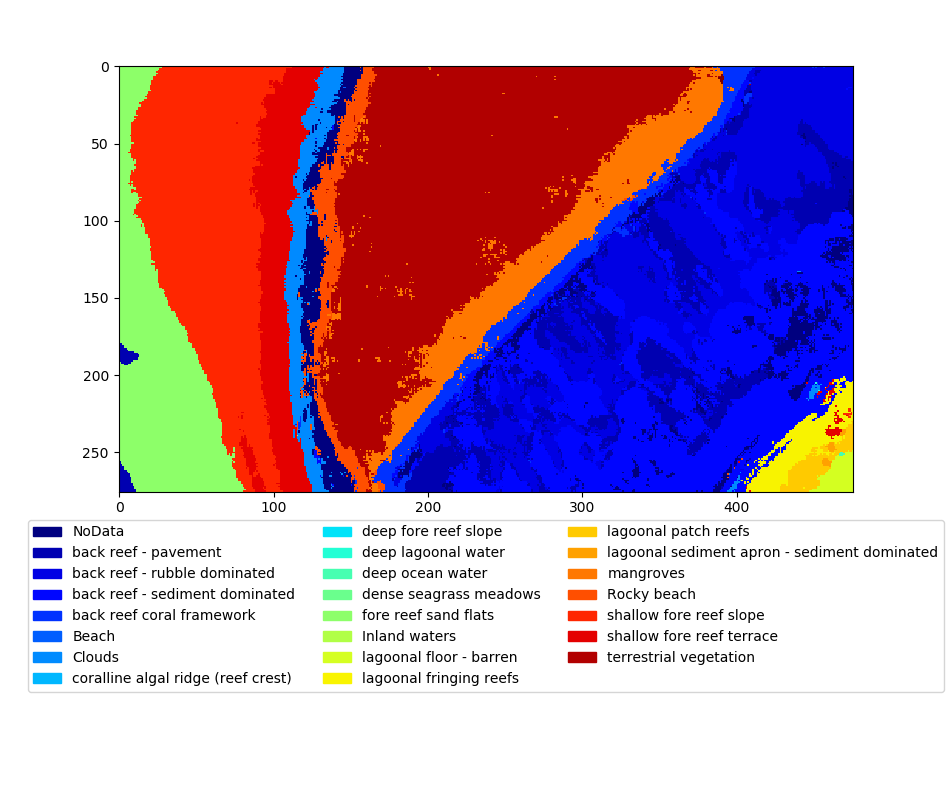

<IPython.core.display.Javascript object>


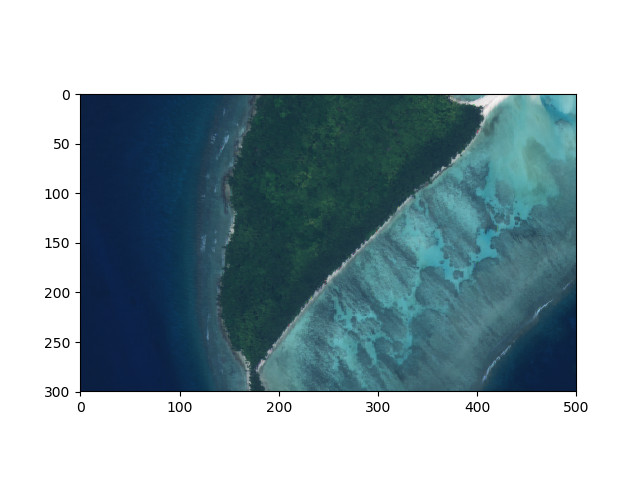

In [39]:
print(whole_predict.shape)
print(Testtruth.shape)
accuracy = 100*np.asarray((whole_predict == Testtruth)).astype(np.float32).sum()/(whole_predict.shape[0]*whole_predict.shape[1])
print(accuracy)
class_indices_rev = dict((v,k) for k,v in train_generator.class_indices.items()) #flip k,v

cmap = plt.cm.get_cmap('jet',24)
# Set borders in the interval [0, 1]
bound = np.linspace(0, 1, 24)
# Preparing borders for the legend
bound_prep = np.round(bound * 7, 2)

fig = plt.figure(2,figsize=(8,8))
ax = plt.subplot(111)
ax.imshow(whole_predict, cmap=cmap)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height])
ax.legend([mpatches.Patch(color=cmap(b)) for b in bound[:-1]],
           ['{}'.format(class_indices_rev[i]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
# ax2.imshow(Testtruth)

plt.show()

plt.figure(3)
plt.imshow(Perostest_RGB)
plt.show()